# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:先训练判别器
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [90]:
import tensorflow as tf
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x): #将图像压缩到-1，1
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """计算当前 TensorFlow graph中参数的数量 """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()]) #prod计算乘积，比如（N，M）的矩阵，参数为N×M
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')

## Dataset
 GANs对超参数非常挑剔，这是出了名的，而且还需要很多训练时间。为了让这个任务在没有GPU的情况下也可以实现，我们将使用MNIST数据集，它包含6万张训练和1万张测试图像。每幅图片都包含一个以黑色背景为中心的白色数字图像(0到9)，这是最早用于训练卷积神经网络的数据集之一，非常简单——一个标准的CNN模型可以轻松地超过99%的准确率
 

**Heads-up**: 我们的MNIST wrapper将图像作为向量返回。也就是说，它们的大小(batch，784)。如果您想将它们视为图像，我们必须将它们调整为(batch,28,28)或(batch,28,28,1)。它们也是np类型。浮点32和有界[0,1]。

Extracting ./cs231n/datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-labels-idx1-ubyte.gz


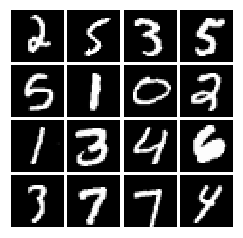

In [91]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])


## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs可以防止ReLU单元死亡，常用于GAN方法中 (与maxout单元一样，但是这些单元增加了模型大小，因此不在本笔记本中使用).

HINT: 使用 `tf.maximum`

In [92]:
def leaky_relu(x, alpha=0.01):
    """计算leaky ReLU激活函数
    
    Inputs:
    - x: TensorFlow Tensor,任意形状
    - alpha: leak参数 for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    # 若x < 0 返回alpha*x ,否则返回x.
    activation = tf.maximum(x,alpha*x)

    return activation 

测试leaky ReLU 实现. 应该得误差 < 1e-10

In [93]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise 随机噪声
创建一个TensorFlow `Tensor` 包含均匀噪声 从-1到1， 形状为 `[batch_size, dim]`.

In [94]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    random_noise = tf.random_uniform(maxval=1,minval=-1,shape=[batch_size, dim])

    return random_noise 

确保噪音是正确的形状和类型:

In [95]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator判别器
第一步建立一个判别器。应该使用`tf.layers` 中的layer建立模型

所有全连接的层都应该包含偏置项。 对于初始化，只需使用默认初始化器used by the `tf.layers` functions.

结构:
 * 全连接层，input size 784 ，output size 256
 * LeakyReLU ， alpha 0.01
 * 全连接层， output size 256
 * LeakyReLU ， alpha 0.01
 * 全连接层，output size 1 
 
鉴别器的输出形状为 `[batch_size, 1]`, 并且包含每个图像的真实性的得分

In [96]:
def discriminator(x):
    """计算一批输入图像的判别器得分。
    
    Inputs:
    - x: TensorFlow Tensor 扁平的输入图像, 形状 [batch_size, 784]
    
    Returns:
    TensorFlow Tensor，形状 [batch_size, 1], 包含每个输入图像为真实图像的得分
    """
    with tf.variable_scope("discriminator"):
        # TODO: 实现结构
        fc1 = tf.layers.dense(inputs=x, units=256, activation=leaky_relu) #输出N×256
        fc2 = tf.layers.dense(inputs=fc1, units=256, activation=leaky_relu) #输出N×256
        logits = tf.layers.dense(inputs=fc2, units=1) #输出N×1
      
        return logits

检查鉴别器参数个数是否正确:

In [97]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator生成器
构建生成器. 使用 `tf.layers` 的layer构建模型. 所有全连接层都应该包含偏置项。 可以使用 tf.nn 模块访问激活函数. 同样，对参数使用默认初始化器。

结构:
 * 全连接层，inupt size tf.shape(z)[1] (噪声的维数) ， output size 1024
 * `ReLU`
 * 全连接层，output size 1024 
 * `ReLU`
 * 全连接层，output size 784
 * `TanH` (将输出的每个元素限制在 [-1,1])

In [98]:
def generator(z):
    """从随机噪声向量生成图像。
    
    Inputs:
    - z: TensorFlow Tensor，随机噪声，形状为 [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(inputs=z, units=1024, activation=tf.nn.relu) #输出N×1024
        fc2 = tf.layers.dense(inputs=fc1, units=1024, activation=tf.nn.relu) #输出N×1024
        img = tf.layers.dense(inputs=fc2, units=784, activation=tf.nn.tanh) #输出N×784
        
        return img

测试，确认生成器的参数数量正确

In [99]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

计算生成器和判别器的 loss. 生成器的loss :
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
判别器的loss：
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
注意，由于我们将“最小化”这些损失，因此前面给出的方程对这些损失进行了取负。

**提示**: 使用 [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like)和 [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) 为判别器生成标签. 使用 [tf.nn.sigmoid_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) 来帮助计算损失函数. 我们不计算期望，而是对minibatch中的元素求平均值， 所以通过求平均结合损失而不是求和.

In [100]:
def gan_loss(logits_real, logits_fake):
    """计算GAN的loss
    
    输入:
    - logits_real: Tensor, 形状为 [batch_size, 1], 判别器的输出，对每个真图像，，图像为真实的非标准化得分
    - logits_fake: Tensor, shape[batch_size, 1], 判别器的输出，对于每个假图像，图像为真实的非标准化得分
    
    返回值：
    - D_loss: 判别器的loss，标量
    - G_loss: 生成器的loss，标量
    
    提示: 对判别器的loss, 要对它的两个分量分别求平均值, 然后把它们加起来(而不是在最后求一次平均值）
    """
    # TODO: compute D_loss and G_loss
    # 目标label向量。G的loss和D的loss
    true_labels = tf.ones_like(logits_fake)
    
    # 判别器的损失，D loss有两部分：对真实图像的分类能力和对假图像的分类能力
    real_image_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=true_labels)
    fake_image_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=1-true_labels)
    
    # 将两部分损失结合，先分别求平均，然后相加
    D_loss = real_image_loss + fake_image_loss 
    D_loss = tf.reduce_mean(D_loss)
    
    #生成器试图使判别器对所有图像的输出都是1
    #所以我们使用值为1的目标标签向量，计算生成器的loss
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=true_labels)
    #计算这批数据生成器loss的平均值
    G_loss = tf.reduce_mean(G_loss)
    
    return D_loss, G_loss

测试 GAN loss.确保判别器和生成器的loss是正确的. You should see errors less than 1e-5.

In [101]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 1.20519e-16
Maximum error in g_loss: 7.19722e-17


# Optimizing our loss优化loss
 `AdamOptimizer` ， 1e-3 学习率, beta1=0.5 ，对 G_loss 和 D_loss 分别进行最小化。降低 beta 的trick有助于GAN收敛 [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) . 事实上，用目前的超参数，如果将beta1设置为0.9，很有可能判别器的loss会降到0，生成器会无法完全学习. 事实上这是GANs中常见的失败模式; 如果判别器D（x）学习得太快（loss降到几乎为0）， 那么生成器 G(z)永远学不会. 通常 D(x) 用动量SGD或 RMSProp优化，而不是  Adam,但是在这里我们对D(x)和 G(z)使用Adam. 

In [102]:
# TODO: 为D_solver和G_solver创建一个AdamOptimizer
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """为GAN的训练创建solvers
    
    输入:
    - learning_rate: 两个求解器solvers 的学习率
    - beta1: 两个求解器的beta1参数(first moment decay)
    
    Returns:
    - D_solver: 实例 tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: 实例 tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

## Putting it all together将各个部分组合
仔细阅读这一部分，理解如何组成生成器和判别器

In [124]:
tf.reset_default_graph()

# 每批次的图像的数量
batch_size = 128
# 噪音的维度
noise_dim = 96

# placeholder：用于训练集中的图像
x = tf.placeholder(tf.float32, [None, 784])
# 生成输入生成器的随机噪声
z = sample_noise(batch_size, noise_dim)
# 生成图像
G_sample = generator(z)

# 判别器对真实图像和假图像的判别共用权重
with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # 在新的输入上重用判别器权重
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# 获取判别器和生成器的变量列表
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# 得到solver求解器
D_solver, G_solver = get_solvers()

# 得到loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# 设置训练的steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!训练GAN
在epoch1后, 应该看到模糊的轮廓,到了epoch5之后，一半应该是清晰可见的。 在我们的例子中，我们在每次迭代中使用一个批处理来训练D(x)和G(z)。然而，论文中经常对D(x)和G(z)试验不同的训练计划，有时候一个的step比另一个多，甚至训练直到损失“足够好”，然后转换到另一个生成器或判别器。

In [111]:
# 辅助函数
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=200, print_every=50, batch_size=128, num_epoch=10):
    """在一定的周期epoch内训练一个GAN
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: 生成器的一个训练step
    - G_loss: 生成器的 loss
    - D_train_step: 判别器的一个training step
    - D_loss: 判别器的 loss
    - G_extra_step: 一个生成器的 tf.GraphKeys.UPDATE_OPS 集合
    - D_extra_step: 一个判别器的 tf.GraphKeys.UPDATE_OPS 集合
    Returns:
        Nothing
    """
    # 计算需要的迭代次数
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # 每次都要显示一个简单的结果
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        
        # 通过网络运行一个批次的数据
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # 打印loss
        # 确认D_loss 没有变成 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('最终的图像')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### 训练GAN，在CPU应该耗时10min，在GPU上少于1min

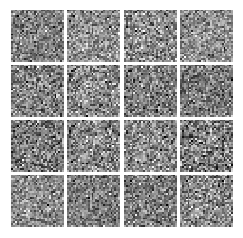


Iter: 0, D: 1.11, G:0.713
Iter: 50, D: 0.2083, G:1.887
Iter: 100, D: 1.043, G:1.358
Iter: 150, D: 1.574, G:1.026


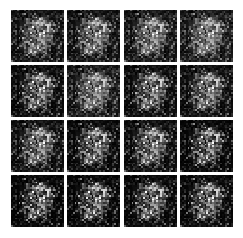


Iter: 200, D: 2.0, G:0.5163
Iter: 250, D: 1.496, G:2.779
Iter: 300, D: 1.887, G:1.196
Iter: 350, D: 2.146, G:0.8876


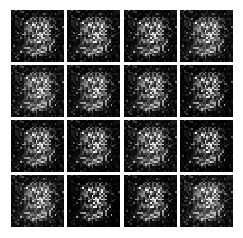


Iter: 400, D: 1.181, G:1.276
Iter: 450, D: 1.024, G:1.637
Iter: 500, D: 1.144, G:2.171
Iter: 550, D: 1.201, G:1.073


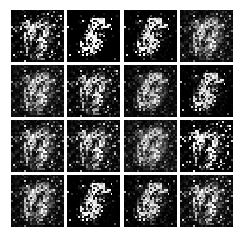


Iter: 600, D: 1.57, G:1.307
Iter: 650, D: 1.047, G:1.224
Iter: 700, D: 0.7492, G:2.207
Iter: 750, D: 1.053, G:0.8386


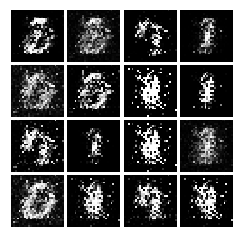


Iter: 800, D: 0.9311, G:1.674
Iter: 850, D: 0.9014, G:2.715
Iter: 900, D: 1.064, G:1.178
Iter: 950, D: 1.197, G:1.481


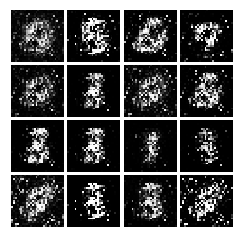


Iter: 1000, D: 1.214, G:0.9505
Iter: 1050, D: 1.291, G:1.219
Iter: 1100, D: 1.277, G:0.8203
Iter: 1150, D: 1.301, G:1.092


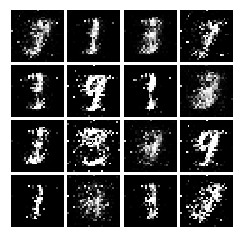


Iter: 1200, D: 1.336, G:0.6646
Iter: 1250, D: 1.419, G:0.8023
Iter: 1300, D: 1.212, G:1.045
Iter: 1350, D: 1.189, G:0.5568


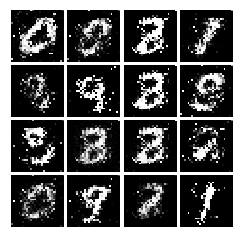


Iter: 1400, D: 1.503, G:1.343
Iter: 1450, D: 1.376, G:1.353
Iter: 1500, D: 1.255, G:0.9526
Iter: 1550, D: 1.289, G:0.8851


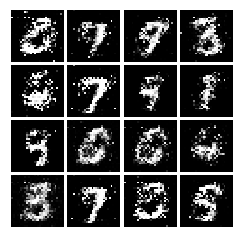


Iter: 1600, D: 1.168, G:1.037
Iter: 1650, D: 1.286, G:1.037
Iter: 1700, D: 1.324, G:0.9575
Iter: 1750, D: 1.282, G:0.8928


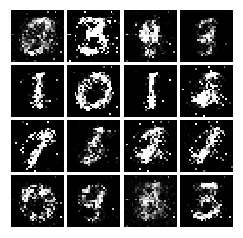


Iter: 1800, D: 1.269, G:0.9379
Iter: 1850, D: 1.284, G:0.8127
Iter: 1900, D: 1.348, G:0.8923
Iter: 1950, D: 1.301, G:0.8063


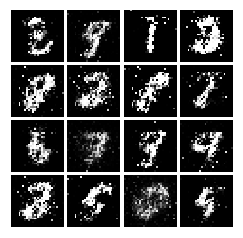


Iter: 2000, D: 1.384, G:0.9366
Iter: 2050, D: 1.324, G:0.8892
Iter: 2100, D: 1.348, G:0.7526
Iter: 2150, D: 1.377, G:0.7878


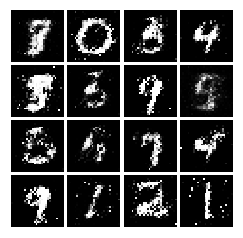


Iter: 2200, D: 1.282, G:1.251
Iter: 2250, D: 1.371, G:0.8234
Iter: 2300, D: 1.242, G:0.8597
Iter: 2350, D: 1.386, G:0.885


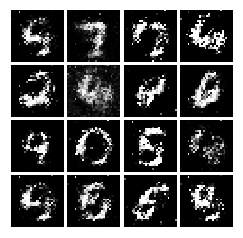


Iter: 2400, D: 1.655, G:0.5581
Iter: 2450, D: 1.291, G:0.8394
Iter: 2500, D: 1.322, G:0.8948
Iter: 2550, D: 1.266, G:1.057


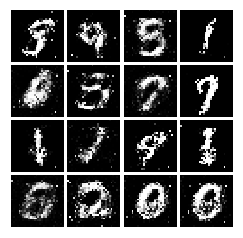


Iter: 2600, D: 1.373, G:0.6909
Iter: 2650, D: 1.347, G:0.9041
Iter: 2700, D: 1.331, G:0.801
Iter: 2750, D: 1.376, G:0.8532


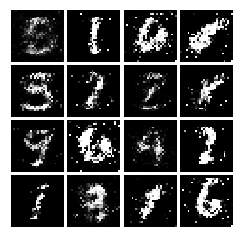


Iter: 2800, D: 1.332, G:0.8182
Iter: 2850, D: 1.356, G:0.7471
Iter: 2900, D: 1.366, G:0.7869
Iter: 2950, D: 1.394, G:0.9044


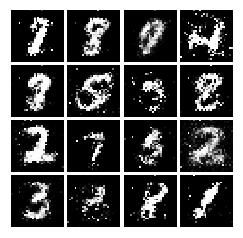


Iter: 3000, D: 1.301, G:0.8742
Iter: 3050, D: 1.368, G:0.762
Iter: 3100, D: 1.379, G:0.7637
Iter: 3150, D: 1.366, G:0.8112


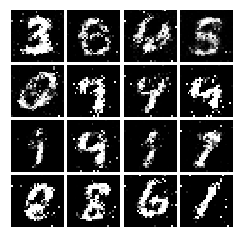


Iter: 3200, D: 1.322, G:0.8581
Iter: 3250, D: 1.329, G:0.7561
Iter: 3300, D: 1.325, G:0.9456
Iter: 3350, D: 1.267, G:0.7958


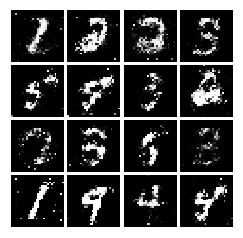


Iter: 3400, D: 1.353, G:0.8777
Iter: 3450, D: 1.326, G:0.8223
Iter: 3500, D: 1.332, G:0.8077
Iter: 3550, D: 1.328, G:0.9397


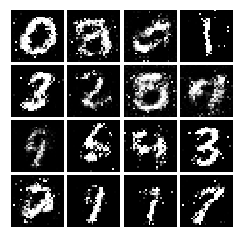


Iter: 3600, D: 1.309, G:0.7781
Iter: 3650, D: 1.369, G:0.7577
Iter: 3700, D: 1.283, G:0.8108
Iter: 3750, D: 1.368, G:0.8597


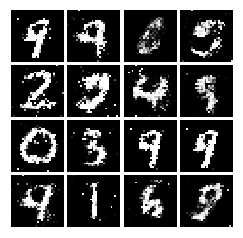


Iter: 3800, D: 1.383, G:0.814
Iter: 3850, D: 1.282, G:1.407
Iter: 3900, D: 1.382, G:0.8528
Iter: 3950, D: 1.338, G:0.896


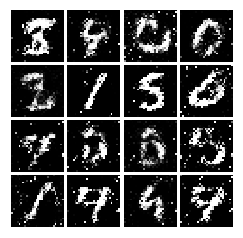


Iter: 4000, D: 1.357, G:1.405
Iter: 4050, D: 1.408, G:0.8035
Iter: 4100, D: 1.316, G:0.8012
Iter: 4150, D: 1.365, G:0.8507


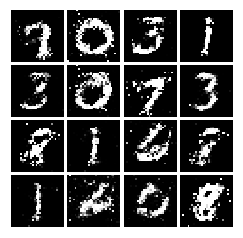


Iter: 4200, D: 1.332, G:0.8308
Iter: 4250, D: 1.279, G:0.8068
最终的图像


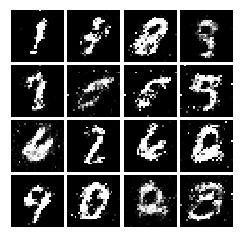

In [112]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN最小二乘GAN
 [Least Squares GAN](https://arxiv.org/abs/1611.04076), 相比于原始的GAN的一个更新的, 更稳定的loss函数。 对于这部分，我们所要做的就是改变损失函数并重新训练模型. 我们将实现文中的等式 (9), 生成器loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
判别器损失：
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**提示**: 我们不计算期望，而是对minibatch的元素求平均值， 从而通过平均而不是求和把loss结合起来。当插入D(x)和D(G(z)时，使用判别器的直接输出(score_real和score_fake)。

In [115]:
def lsgan_loss(scores_real, scores_fake):
    """计算最小二乘GAN的loss
    
    Inputs:
    - scores_real: Tensor, shape [batch_size, 1], output of discriminator
        每个真实图像的得分score
    - scores_fake: Tensor, shape[batch_size, 1], output of discriminator
        The score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    true_labels = tf.ones_like(scores_fake)
    fake_image_loss = tf.reduce_mean((scores_real - true_labels)**2)
    real_image_loss = tf.reduce_mean(scores_fake**2)
    D_loss = 0.5*(fake_image_loss + real_image_loss)
    
    G_loss = 0.5*tf.reduce_mean((scores_fake - true_labels)**2)
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [116]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


创建新的训练，减少LSGAN的损失: the LSGAN loss:

In [117]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

运行下面的单元，训练新的模型

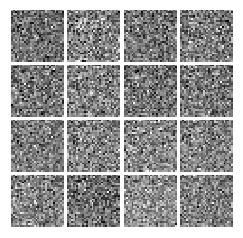


Iter: 0, D: 0.3515, G:0.5074
Iter: 50, D: 0.1175, G:0.8958
Iter: 100, D: 0.02138, G:0.5868
Iter: 150, D: 0.1436, G:0.3777


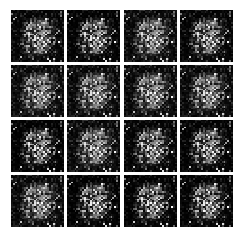


Iter: 200, D: 0.09384, G:0.3823
Iter: 250, D: 0.1608, G:0.4542
Iter: 300, D: 0.1245, G:0.1328
Iter: 350, D: 0.1542, G:0.7665


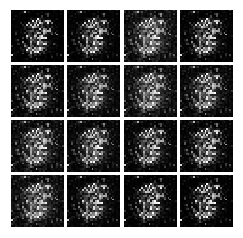


Iter: 400, D: 0.1109, G:0.3685
Iter: 450, D: 0.1294, G:0.555
Iter: 500, D: 0.08467, G:0.7521
Iter: 550, D: 0.1465, G:0.4643


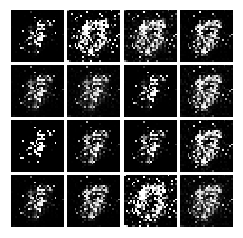


Iter: 600, D: 0.07865, G:0.3789
Iter: 650, D: 0.1076, G:0.5973
Iter: 700, D: 0.1207, G:0.5899
Iter: 750, D: 0.1951, G:0.221


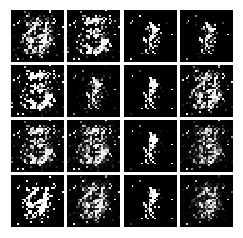


Iter: 800, D: 0.142, G:0.5632
Iter: 850, D: 0.1318, G:0.5018
Iter: 900, D: 0.1424, G:0.5337
Iter: 950, D: 0.1945, G:0.3983


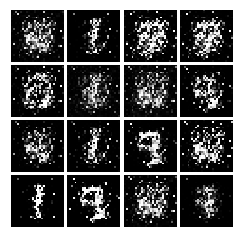


Iter: 1000, D: 0.1549, G:0.5765
Iter: 1050, D: 0.157, G:0.4506
Iter: 1100, D: 0.137, G:0.4218
Iter: 1150, D: 0.1622, G:0.2406


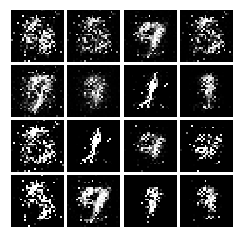


Iter: 1200, D: 0.1767, G:0.7918
Iter: 1250, D: 0.1686, G:0.2373
Iter: 1300, D: 0.1803, G:0.2349
Iter: 1350, D: 0.1739, G:0.5435


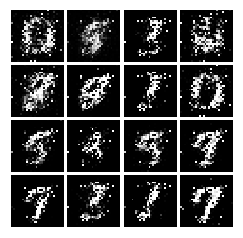


Iter: 1400, D: 0.2113, G:0.2343
Iter: 1450, D: 0.1862, G:0.2369
Iter: 1500, D: 0.2041, G:0.2101
Iter: 1550, D: 0.2219, G:0.2017


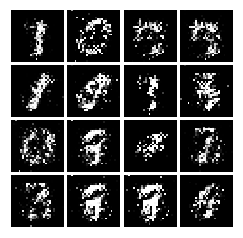


Iter: 1600, D: 0.4151, G:0.2027
Iter: 1650, D: 0.2004, G:0.232
Iter: 1700, D: 0.1622, G:0.2716
Iter: 1750, D: 0.1922, G:0.2771


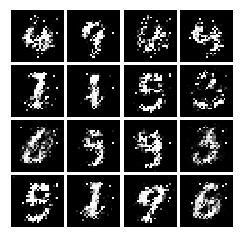


Iter: 1800, D: 0.1842, G:0.1867
Iter: 1850, D: 0.1827, G:0.3023
Iter: 1900, D: 0.1901, G:0.2167
Iter: 1950, D: 0.2267, G:0.215


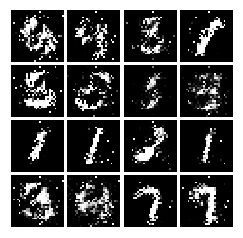


Iter: 2000, D: 0.1908, G:0.2008
Iter: 2050, D: 0.1974, G:0.1948
Iter: 2100, D: 0.2163, G:0.1981
Iter: 2150, D: 0.219, G:0.2227


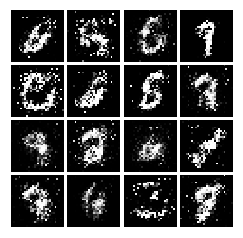


Iter: 2200, D: 0.2381, G:0.1729
Iter: 2250, D: 0.2143, G:0.1698
Iter: 2300, D: 0.2186, G:0.1819
Iter: 2350, D: 0.2013, G:0.1732


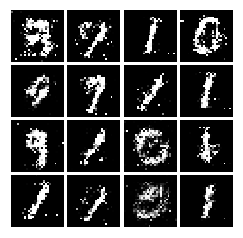


Iter: 2400, D: 0.2334, G:0.1902
Iter: 2450, D: 0.205, G:0.2025
Iter: 2500, D: 0.2002, G:0.1434
Iter: 2550, D: 0.2232, G:0.1966


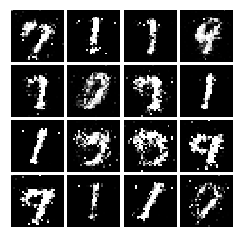


Iter: 2600, D: 0.2403, G:0.2397
Iter: 2650, D: 0.23, G:0.2788
Iter: 2700, D: 0.1998, G:0.1964
Iter: 2750, D: 0.2479, G:0.1307


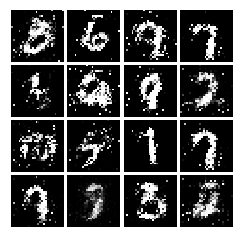


Iter: 2800, D: 0.2344, G:0.1545
Iter: 2850, D: 0.2164, G:0.2095
Iter: 2900, D: 0.1941, G:0.1827
Iter: 2950, D: 0.2247, G:0.1621


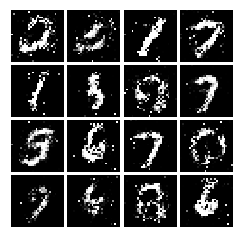


Iter: 3000, D: 0.201, G:0.2098
Iter: 3050, D: 0.2225, G:0.1699
Iter: 3100, D: 0.2077, G:0.1786
Iter: 3150, D: 0.2257, G:0.1673


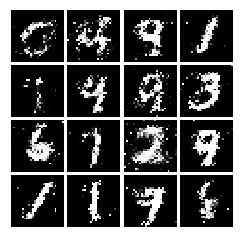


Iter: 3200, D: 0.2271, G:0.1601
Iter: 3250, D: 0.2352, G:0.1752
Iter: 3300, D: 0.2368, G:0.1998
Iter: 3350, D: 0.2018, G:0.1947


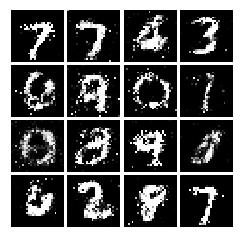


Iter: 3400, D: 0.2083, G:0.2041
Iter: 3450, D: 0.2192, G:0.2041
Iter: 3500, D: 0.2259, G:0.1759
Iter: 3550, D: 0.2285, G:0.1754


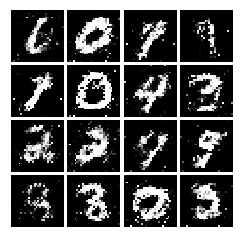


Iter: 3600, D: 0.2062, G:0.1988
Iter: 3650, D: 0.216, G:0.1694
Iter: 3700, D: 0.2212, G:0.1684
Iter: 3750, D: 0.2157, G:0.2003


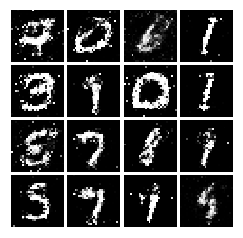


Iter: 3800, D: 0.2029, G:0.1906
Iter: 3850, D: 0.2137, G:0.1641
Iter: 3900, D: 0.2317, G:0.1975
Iter: 3950, D: 0.2283, G:0.1828


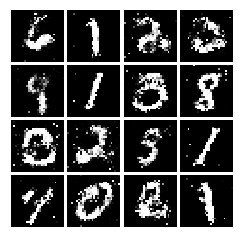


Iter: 4000, D: 0.221, G:0.1829
Iter: 4050, D: 0.2286, G:0.1929
Iter: 4100, D: 0.2315, G:0.1694
Iter: 4150, D: 0.2271, G:0.1631


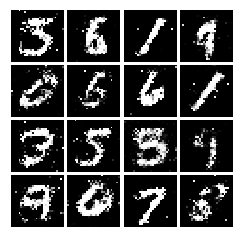


Iter: 4200, D: 0.2347, G:0.1669
Iter: 4250, D: 0.228, G:0.1765
最终的图像


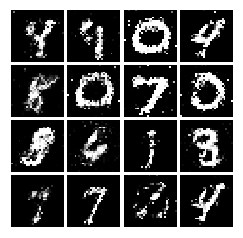

In [118]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# Deep Convolutional GANs DCGAN 深度卷积GAN
在笔记本的第一部分中，我们实现了一个几乎直接复制Ian Goodfellow的原始GAN网络。然而，这种网络架构不允许真正的空间推理。 它无法推理出像“尖锐边缘”之类的东西，因为它没有任何卷积层。因此，在本节中，我们将实现 [DCGAN](https://arxiv.org/abs/1511.06434), 用卷积网络作为判别器和生成器

#### Discriminator判别器
我们将使用一个受TensorFlow MNIST分类启发的判别器 [tutorial](https://www.tensorflow.org/get_started/mnist/pros), 它能够在MNIST数据集上相当快地获得99%以上的精度。*一定要检查x的维度，并在必要时reshape*, 全连接块 expect [N,D] Tensors ，conv2d blocks expect [N,H,W,C] Tensors. 使用 `tf.layers` 定义下边的结构:

架构:
* Conv2D: 32 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

同样，请对所有卷积和全连接的层使用偏置bias，并使用默认参数初始化器。注意padding of 0 可以使用'VALID' padding 选项.

In [120]:
def discriminator(x):
    """计算一批输入图像的判别器得分。
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], 包含每个输入图像为真实图像的score。
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        input_reshape = tf.reshape(x,shape=[-1,28,28,1])
        conv_1 = tf.layers.conv2d(inputs = input_reshape,kernel_size = 5,strides=1,filters=32 ,activation=leaky_relu)
        maxpool_1 = tf.layers.max_pooling2d(inputs=conv_1, pool_size=2, strides=2)
        conv_2 = tf.layers.conv2d(inputs=maxpool_1, kernel_size=5, strides=1, filters=64,activation=leaky_relu)
        maxpool_2 = tf.layers.max_pooling2d(inputs=conv_2, pool_size=2, strides=2)
        flatten = tf.reshape(maxpool_2,shape=[-1,1024])
        fc_1 = tf.layers.dense(inputs=flatten, units=1024, activation=leaky_relu)
        logits = tf.layers.dense(inputs=fc_1, units=1)
        
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator生成器
对于生成器，参考文章 [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. 使用 `tf.layers` 实现. 文档 [tf.layers.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose) 有用. 架构如下：

架构:
* Fully connected with output size 1024 
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Resize into Image Tensor of size 7, 7, 128
* Conv2D^T (transpose): 64 filters of 4x4, stride 2
* `ReLU`
* BatchNorm
* Conv2d^T (transpose): 1 filter of 4x4, stride 2
* `TanH`

对全连接层和反卷积层使用偏置bias. 请为参数使用默认初始化器。 For padding, choose the 'same' option for transpose convolutions. For Batch Normalization, assume we are always in 'training' mode.

In [121]:
def generator(z):
    """从随机噪声向量生成图像。
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc_1 = tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu)
        bn_1 = tf.layers.batch_normalization(inputs=fc_1,training=True)
        fc_2 = tf.layers.dense(inputs=bn_1,units=7*7*128,activation=tf.nn.relu)
        bn_2 = tf.layers.batch_normalization(inputs=fc_2,training=True)
        img_reshape = tf.reshape(bn_2,shape=[-1,7,7,128])
        conv_trans_1 = tf.layers.conv2d_transpose(inputs=img_reshape,
                                  filters=64,kernel_size=4, strides=2, 
                                  activation=tf.nn.relu,padding='same') 
        bn_3 = tf.layers.batch_normalization(inputs=conv_trans_1,training=True)
        conv_trans_2 = tf.layers.conv2d_transpose(inputs=bn_3,
                                  filters=1,kernel_size=4, strides=2, 
                                  activation=tf.nn.tanh,padding='same') 
        img = tf.reshape(conv_trans_2,shape=[-1,784])
        return img
test_generator(6595521)

Correct number of parameters in generator.


我们必须重建网络，因为我们已经改变了函数。

In [122]:
tf.reset_default_graph()

batch_size = 128
# 噪声的维度
noise_dim = 96

# placeholders：训练数据集中的数据
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim) #生成随机噪声
# 从噪声生成图像
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #缩放图像为-1到1
    logits_real = discriminator(preprocess_img(x))
    # 在新的输入上重用判别器的权重
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# 获取判别器和生成器的变量列表
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### 训练和评估 DCGAN
这是A3中使用GPU的一个显著优点。 它需要3分钟的GPU运行5个epoch。 或者在CPU上的双核笔记本电脑上运行大约50分钟 (feel free to use 3 epochs if you do it on CPU).

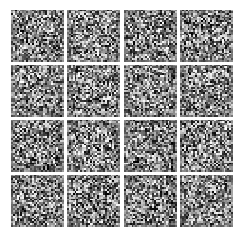


Iter: 0, D: 1.346, G:0.6713
Iter: 50, D: 0.7498, G:1.351
Iter: 100, D: 0.587, G:1.797
Iter: 150, D: 0.8527, G:1.026


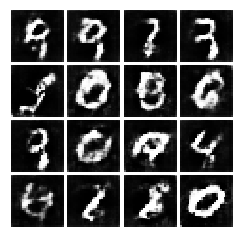


Iter: 200, D: 0.9552, G:0.8637
Iter: 250, D: 1.067, G:0.9727
Iter: 300, D: 1.118, G:0.8672
Iter: 350, D: 1.089, G:0.8819


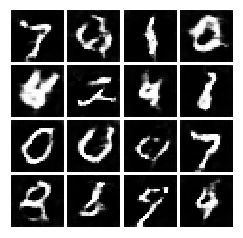


Iter: 400, D: 1.075, G:1.018
Iter: 450, D: 1.172, G:1.179
Iter: 500, D: 1.115, G:1.042
Iter: 550, D: 1.199, G:1.034


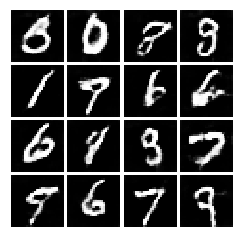


Iter: 600, D: 1.119, G:0.7102
Iter: 650, D: 1.139, G:0.8342
Iter: 700, D: 1.408, G:0.9126
Iter: 750, D: 1.123, G:0.8613


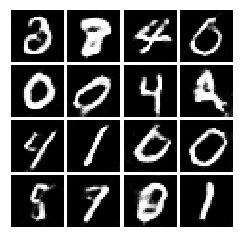


Iter: 800, D: 1.17, G:0.9383
Iter: 850, D: 1.114, G:0.9714
Iter: 900, D: 1.566, G:0.7672
Iter: 950, D: 1.128, G:0.8652


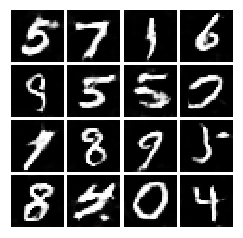


Iter: 1000, D: 1.107, G:1.085
Iter: 1050, D: 1.145, G:1.01
Iter: 1100, D: 1.259, G:0.9668
Iter: 1150, D: 1.133, G:1.045


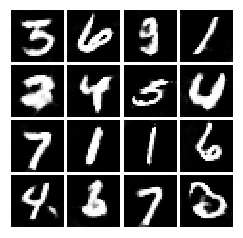


Iter: 1200, D: 1.22, G:0.8601
Iter: 1250, D: 1.385, G:0.7557
Iter: 1300, D: 1.348, G:0.7046
Iter: 1350, D: 1.237, G:0.9833


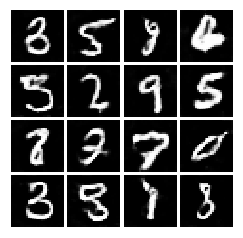


Iter: 1400, D: 1.161, G:1.081
Iter: 1450, D: 1.333, G:0.6172
Iter: 1500, D: 1.213, G:1.823
Iter: 1550, D: 1.211, G:1.024


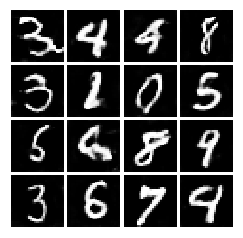


Iter: 1600, D: 1.116, G:1.013
Iter: 1650, D: 1.281, G:0.6093
Iter: 1700, D: 1.118, G:0.9947
Iter: 1750, D: 1.1, G:1.002


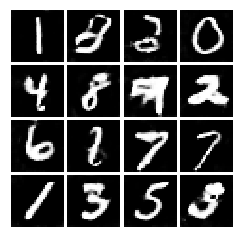


Iter: 1800, D: 1.156, G:0.6815
Iter: 1850, D: 1.075, G:1.183
Iter: 1900, D: 1.155, G:1.156
Iter: 1950, D: 1.074, G:1.186


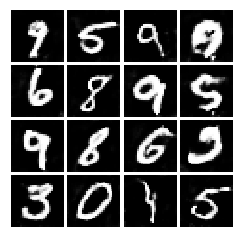


Iter: 2000, D: 1.363, G:1.235
Iter: 2050, D: 1.238, G:1.267
Iter: 2100, D: 1.121, G:1.387
最终的图像


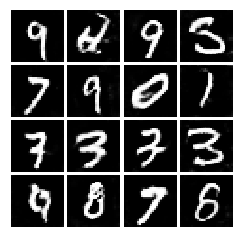

In [123]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

## INLINE QUESTION 1

我们将通过一个例子来了解为什么相同目标(比如GAN)的交替最小化是一件棘手的事情。

考虑 $f(x,y)=xy$.  $\min_x\max_y f(x,y)$ 等于多少? (提示:minmax试图最小化可实现的最大值。）

现在试着用6步来计算这个函数，从 $(1,1)$开始, 
通过使用交替梯度(首先更新y，然后更新x) ，使用步长为 $1$. 
You'll find that writing out the update step in terms of $x_t,y_t,x_{t+1},y_{t+1}$ will be useful.

记录六对显式值 for $(x_t,y_t)$ in the table below.

### Your answer:
 
 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$ 
 ----- | ----- | ----- | ----- | ----- | ----- | ----- 
   1   |   2   |    2   |  3   |   3   |   2   |   2   
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$ 
   1   |   1    |   0   |  0   |   -1   |  -1   |  -2    
   

## INLINE QUESTION 2
Using this method, will we ever reach the optimal value? Why or why not?
用这种方法，我们会得到最优值吗?为什么?

定义一个最优化问题即目标函数，可以证明最优生成器 G 满足 P_G(x)=P_data(x)。所以可以合理地期望神经网络通过典型的 SGD 训练就能得到最优的 G。

### Your answer:

## INLINE QUESTION 3
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient
如果在训练过程中生成器loss减小，而判别器loss从一开始就保持在一个恒定的高值，这是一个好迹象吗? 为什么呢？ 一个定性的回答就可以



### Your answer:

# WGAN-GP

[Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) 更新的, 跟稳定的损失函数相比于原始的GAN.对于这部分，我们所要做的就是改变损失函数并重新训练模型。我们将实现算法1。

还需要使用生成器和判别器（不带最大池化）。 所以我们不能使用DCGAN的。Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (我们不使用Q，只实现网络到D). 如果您想使用本笔记本顶部使用的D(x)和G(z)的全连接，也欢迎您在本笔记本中定义一个新的生成器和判别器。

架构:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [125]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        init = tf.contrib.layers.xavier_initializer()
        x = tf.reshape(x, [-1, 28, 28, 1])
        conv_1 = tf.layers.conv2d(x, 64, 4, activation=leaky_relu, strides=2, padding='valid',
                             kernel_initializer=init)
        conv_1 = tf.layers.conv2d(conv_1, 128, 4, activation=leaky_relu, strides=2, padding='valid',
                             kernel_initializer=init)
        bn_1 = tf.layers.batch_normalization(conv_1,training = True)
        flatten = tf.reshape(bn_1, [-1, 3200])
        fc_1 = tf.layers.dense(flatten, 1024, activation=leaky_relu, kernel_initializer=init)
        logits = tf.layers.dense(fc_1, 1, kernel_initializer=init)
        return logits
test_discriminator(3411649)

Correct number of parameters in discriminator.


In [127]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [128]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    
    D_loss = - tf.reduce_mean(logits_real) + tf.reduce_mean(logits_fake)
    G_loss = - tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size,1], minval=0.0, maxval=1.0)
    x_hat = eps*x+(1-eps)*G_sample
    #diff = G_sample - x
    #interp = x + (eps * diff)
    
    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)
    
    grad_norm = tf.norm(grad_D_x_hat[0], axis=1, ord='euclidean')
    grad_pen = tf.reduce_mean(tf.square(grad_norm-1))
    #slopes = tf.sqrt(tf.reduce_sum(tf.square(grad_D_x_hat), reduction_indices=[1]))
    #grad_pen = tf.reduce_mean((slopes - 1.) ** 2)
    
    
    D_loss += lam*grad_pen

    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

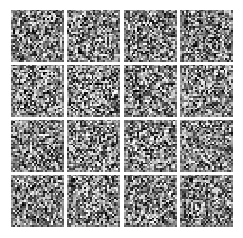


Iter: 0, D: 17.02, G:-0.5779
Iter: 50, D: -2.79, G:-6.459
Iter: 100, D: -2.342, G:-0.4521
Iter: 150, D: -1.9, G:-4.751


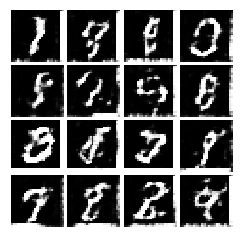


Iter: 200, D: -2.957, G:-3.899
Iter: 250, D: -0.1422, G:2.345
Iter: 300, D: -0.1547, G:-0.2642
Iter: 350, D: -0.06981, G:-0.141


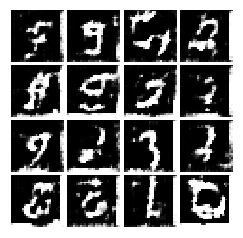


Iter: 400, D: 0.07978, G:-2.835
Iter: 450, D: -0.0683, G:0.3852
Iter: 500, D: -0.1154, G:-1.486
Iter: 550, D: 0.3247, G:-3.02


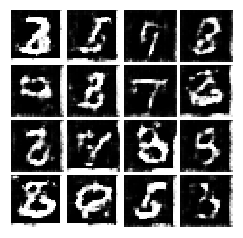


Iter: 600, D: 0.1581, G:-0.265
Iter: 650, D: -0.4679, G:-3.427
Iter: 700, D: -0.6976, G:-3.071
Iter: 750, D: -0.287, G:-1.378


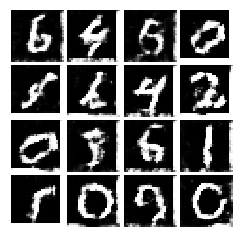


Iter: 800, D: -0.4072, G:-1.223
Iter: 850, D: -1.528, G:-6.251
Iter: 900, D: -1.622, G:-6.432
Iter: 950, D: -0.7931, G:-1.925


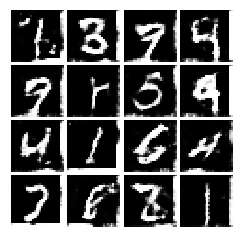


Iter: 1000, D: -1.825, G:-4.99
Iter: 1050, D: -1.408, G:-5.557
Iter: 1100, D: -0.9721, G:-4.12
Iter: 1150, D: -1.073, G:-9.995


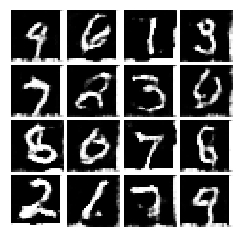


Iter: 1200, D: -0.7219, G:-3.539
Iter: 1250, D: -1.42, G:-2.186
Iter: 1300, D: -3.283, G:-2.668
Iter: 1350, D: -2.568, G:-11.17


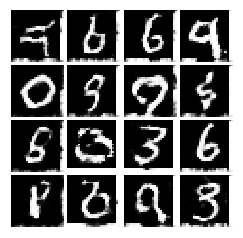


Iter: 1400, D: -1.317, G:-7.535
Iter: 1450, D: -0.7036, G:-10.62
Iter: 1500, D: -0.6688, G:-1.154
Iter: 1550, D: -0.6182, G:-1.942


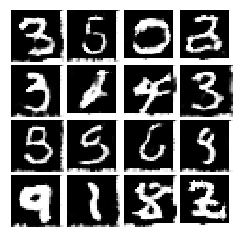


Iter: 1600, D: -1.238, G:-6.123
Iter: 1650, D: -0.7249, G:-4.982
Iter: 1700, D: -1.571, G:-6.219
Iter: 1750, D: -0.4775, G:-6.041


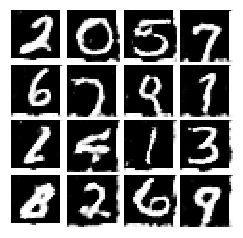


Iter: 1800, D: 0.1863, G:-12.49
Iter: 1850, D: -1.763, G:-1.692
Iter: 1900, D: -2.226, G:-9.606
Iter: 1950, D: -2.17, G:-12.07


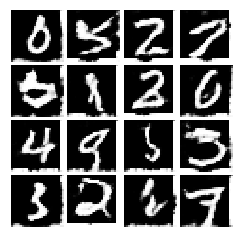


Iter: 2000, D: -2.006, G:-6.883
Iter: 2050, D: -2.763, G:-19.2
Iter: 2100, D: -2.908, G:-3.909
Iter: 2150, D: 0.9755, G:-4.002


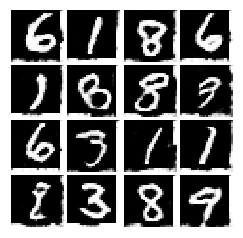


Iter: 2200, D: -0.3727, G:0.8817
Iter: 2250, D: -0.1136, G:-6.283
Iter: 2300, D: -0.3332, G:-2.49
Iter: 2350, D: -0.3496, G:-0.9856


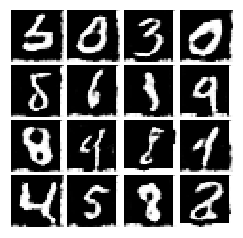


Iter: 2400, D: 0.1545, G:-4.678
Iter: 2450, D: 0.3154, G:-4.778
Iter: 2500, D: -0.1698, G:-5.039
Iter: 2550, D: -0.5614, G:-1.312


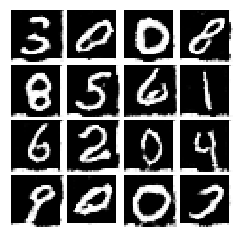


Iter: 2600, D: -0.5721, G:-3.421
Iter: 2650, D: -1.205, G:-5.052
Iter: 2700, D: -1.082, G:-11.3
Iter: 2750, D: -1.029, G:-7.376


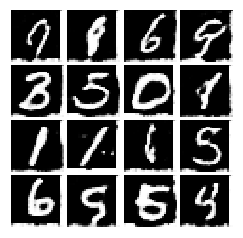


Iter: 2800, D: -1.498, G:-6.929
Iter: 2850, D: -1.139, G:-2.589
Iter: 2900, D: 0.3256, G:-2.868
Iter: 2950, D: -1.285, G:-9.459


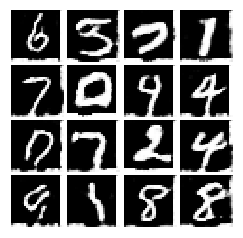


Iter: 3000, D: -0.2827, G:-2.728
Iter: 3050, D: -2.172, G:-7.445
Iter: 3100, D: -1.023, G:-14.16
Iter: 3150, D: -1.02, G:-4.051


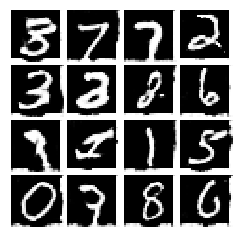


Iter: 3200, D: -1.653, G:-16.41
Iter: 3250, D: -1.789, G:-10.71
Iter: 3300, D: -2.081, G:-6.392
Iter: 3350, D: 0.1177, G:-5.798


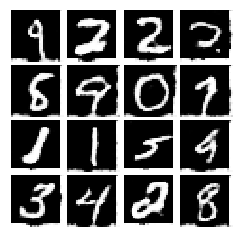


Iter: 3400, D: -2.248, G:-13.63
Iter: 3450, D: 0.3101, G:1.895
Iter: 3500, D: 0.3939, G:0.7101
Iter: 3550, D: 0.441, G:2.852


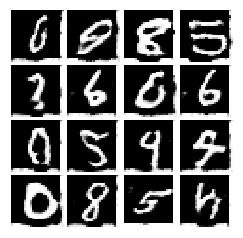


Iter: 3600, D: 0.2588, G:1.485
Iter: 3650, D: -0.1008, G:2.155
Iter: 3700, D: 0.004983, G:1.51
Iter: 3750, D: -0.2372, G:1.143


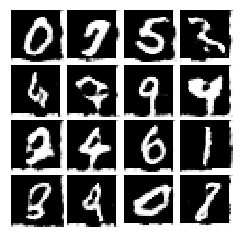


Iter: 3800, D: 0.07801, G:1.237
Iter: 3850, D: 0.1974, G:1.782
Iter: 3900, D: 0.4504, G:1.992
Iter: 3950, D: -0.288, G:0.9135


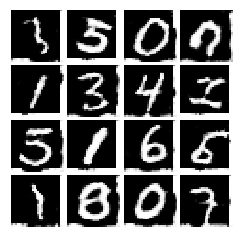


Iter: 4000, D: -0.298, G:1.979
Iter: 4050, D: 0.7855, G:0.7776
Iter: 4100, D: 0.147, G:-0.5257
Iter: 4150, D: -0.1499, G:3.972


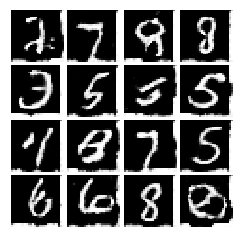


Iter: 4200, D: 0.3288, G:0.1324
Iter: 4250, D: -0.3501, G:0.3779
最终的图像


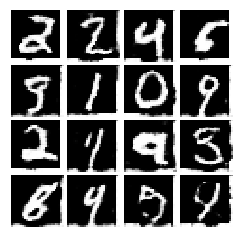

In [129]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=10)